# Project: Incidence and Rationale for Patients Missing their Appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this report, we will analyse a dataset of 100K medical appintment records from patients in Brazil. The dataset contains information of whether the patients show up for their appointments are not. The dataset also contains information whether the patient is enrolled in the Brazilian welfare program. The appointment data also has the date on which the appointment was scheduled as well as the actual appointment date itself. In addition, various physical and physiological characteristics of the patient are also provided such as hypertension, handicap, alcoholism etc.

We will try to understand the coorelation between the missed appointments and other factors such as whether the patient was enrolled in the welfare program. Does the day of the week when the appointment was schedule for matter whether the patient shows up or not? Or there particular neighbourhoods more prone to missing appointments. How about the gap between the day on which the appointment is booked and the appointment date itself - does this infuence the incidence of missing appointments in any way? Does the habits of the patient (eg: alcoholism) cause them to miss an appointment, or on the other hand does a medical condition (eg: hypertension) increase the chances that they show up to an appointment?

We will seek to investigate these parameters.

In [489]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [490]:
# load the data and check for consistency
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Observations
> The data has been read successfully from the csv and no special handling of datafile is needed. A couple of columns have a different naming convention than the others and this could be changed in order to keep consistency. A few other columns (handcap, hipertension) seem to have spelling typos and this could be corrected as well.
<br><br>
Interestingly it looks like the date on which the appointment was scheduled has a time whereas the date of the appointment itself has no time associated, at least in the first few rows.

In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Observations
> The data imported seems to be quite clean. There are no null entries in any of the columns and all data seems to be usable. The data types are mostly integers and strings. There are a few opportunties to clean up the data.
<br><br>
a. Some of the data represented as 0s and 1s could be converted to boolean so that conditional statements make sense.<br>
b. Similarly, the patientid data could be converted to int64 as these are numeric and it will be more readable as integer numbers without the exponential notations.<br>
c. The date information is present as strings and this could be converted into datetime format. In addition, useful information from these dates such as day of week and month could be extracted and stored as new columns in order to aid analysis going forward.


### Data Cleaning 
1) Rename Columns<br>
2) Convert ID to type Int<br>
3) Convert date strings to datetime format<br>
4) Extract day of week and month from datetimes<br>
5) Convert columns which have 0/1 values to boolean

In [492]:
# Fix misspelt columns (to english spellings) and normalize column names for consistency
df.rename(columns={'AppointmentID': 'AppointmentId', 'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SmsReceived', 'No-show': 'NoShow'}, inplace=True)
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [493]:
# cast PatientId from float to int so that it is more readable
df['PatientId'] = df['PatientId'].astype(np.int64) 
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [494]:
# Convert ScheduledDay to datetime and extract important paramters about the date
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['ScheduledDayOfWeek'] = df['ScheduledDay'].dt.dayofweek
df['ScheduledMonth'] = df['ScheduledDay'].dt.month

df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDayOfWeek,ScheduledMonth
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4


In [495]:
# Similarly convert AppointmentDay to datetime and extract important paramters about the date
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['AppointmentDayOfWeek'] = df['AppointmentDay'].dt.dayofweek
df['AppointmentMonth'] = df['AppointmentDay'].dt.month

df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDayOfWeek,ScheduledMonth,AppointmentDayOfWeek,AppointmentMonth
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4,4,4
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4,4,4
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4,4,4
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4,4,4
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4,4,4


In [496]:
# Let us also calculate the time period between the booking of the appointment and the actual appointment date
df['DaysToAppointment'] = df['AppointmentDay'] - df['ScheduledDay'].dt.normalize()
df['DaysToAppointment'] = df['DaysToAppointment'].dt.days
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDayOfWeek,ScheduledMonth,AppointmentDayOfWeek,AppointmentMonth,DaysToAppointment
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4,4,4,0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4,4,4,0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4,4,4,0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4,4,4,0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4,4,4,0


#### From exploration of data in the steps further below, the following bad data came up which could be cleaned before analysis

In [498]:
# the two values of age -1 and 115 seem to be clear outliers / errors and are skewing the data. 
# We'll drop them and proceed.
df = df.query('(Age >=0) & (Age <=100)')
df[('Age')].value_counts().tail()

96     17
97     11
98      6
100     4
99      1
Name: Age, dtype: int64

In [499]:
# There are a few records where the appointment date was before the date on which it was scheduled. 
# We will remove these data before proceeding
df = df.query('DaysToAppointment >= 0')
df['DaysToAppointment'].sort_values().head()

0        0
57784    0
57785    0
57786    0
57787    0
Name: DaysToAppointment, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### Let us first try to understand the data in some more detail

Patients =  62294
Appointments =  110514
mean appointments per person =  1.774071339133785


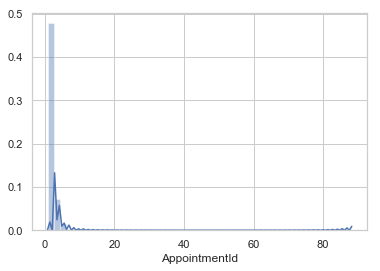

In [500]:
print('Patients = ', df[('PatientId')].unique().size)
print('Appointments = ', df[('AppointmentId')].unique().size)
app_count = df.groupby('PatientId').AppointmentId.count().sort_values(ascending=False)
print("mean appointments per person = ", app_count.mean())
sns.distplot(app_count);

#### Observations
> The number of appointment IDs is the same as the number of records in the dataset. This is consistent.
Also the number of patients is 60K vs 110K total appointments. This shows that some patients have more than one appointment.
<br><br>
There is a large spread in the number of appointments per patient with the distribution heavily skewed to the right. A large %age is within 10 appointments with a huge number of single appointments, whereas there are only a few with more than 10. The reason for these appointments could be appointments made over time - being repeat patients, and not necessarily rescheduling due missing an appointment. We can explore this futher later if need be.
<br><br>
The mean number of appointments per person is 1.78

In [501]:
# Check the unique values in some of the columns which will help us understand the data better
print('Gender : ', df['Gender'].unique())
print('Scholarship : ', df['Scholarship'].unique())
print('Hypertension : ', df['Hypertension'].unique())
print('Diabetes : ', df['Diabetes'].unique())
print('Alcoholism : ', df['Alcoholism'].unique())
print('Handicap : ', df['Handicap'].unique())
print('SmsReceived : ', df['SmsReceived'].unique())
print('NoShow : ', df['NoShow'].unique())

Gender :  ['F' 'M']
Scholarship :  [0 1]
Hypertension :  [1 0]
Diabetes :  [0 1]
Alcoholism :  [0 1]
Handicap :  [0 1 2 3 4]
SmsReceived :  [0 1]
NoShow :  ['No' 'Yes']


#### Observations
> Handicap seems to have 5 levels. Maybe 0 indicates no handicap whereas 1-4 indicates levels of handicap. It might also indicate different types of handicaps.<br>
All other data seems straightforward boolean. NoShow indicates two states as well.

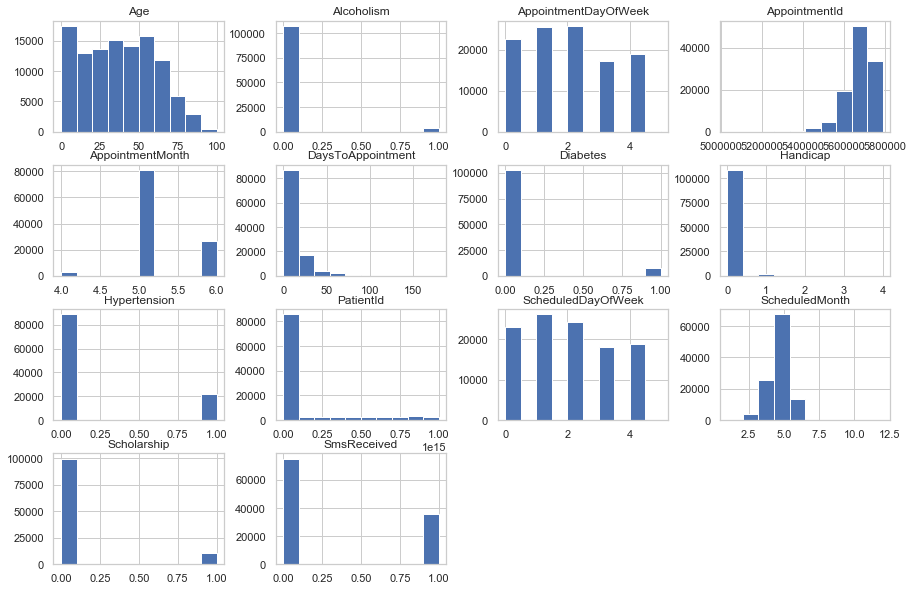

In [502]:
df.hist(figsize=(15,10));

#### Observations
> From looking at the distributions, a few things stand out. <br>
1) Appointments are made in month 4,5,6 with month appointments in May(5), whereas it is was scheduled between months 2-6. Maybe there were some appointments scheduled well in advance where the appointments were missed.<br>
2) A large number of patients didn't have scholarships <br>
3) Appointments were scheduled for weekdays and not weekends


### Q1: Is there a relation between physiological / medical conditions and missing the appointment

In [503]:
# defining some helper functions to plot the data in a repeatable way
def plot_rel_noshow(df, col, ax=None, kind='bar', stacked=True, percent=True, diff=False, 
                    max_threshold=100, min_threshold=0, debug=False, nograph=False, marker=None):
    data = df.groupby([col, 'NoShow']).NoShow.count().unstack().dropna()
    data = data.apply(lambda x: x * 100 / sum(x), axis=1) if percent == True else data
    data = data.apply(lambda x: x['No'] - x['Yes'], axis=1) if diff == True else data

    xticks = None
    if diff:
        data = pd.DataFrame(data).reset_index()
        data.columns = [data.columns[0], 'Diff']
        if max_threshold < 100:
            data = data.query('Diff < {}'.format(max_threshold))
        if min_threshold > 0:
            data = data.query('Diff > {}'.format(min_threshold))
        data = data.set_index(col)

    if debug == True:
        print(data)
        
    if not nograph == True:
        data.plot(ax=ax, kind=kind, stacked=stacked, xticks=xticks)
    
    # rotate label to be horizontal
    if ax is not None:
        for tick in ax.get_xticklabels():
            tick.set_rotation('horizontal')

# plot_rel_noshow(df, 'Diabetes')
# plot_rel_noshow(df, 'Age', kind='line', stacked=False, percent=True, diff=True, max_threshold=52, min_threshold=43)

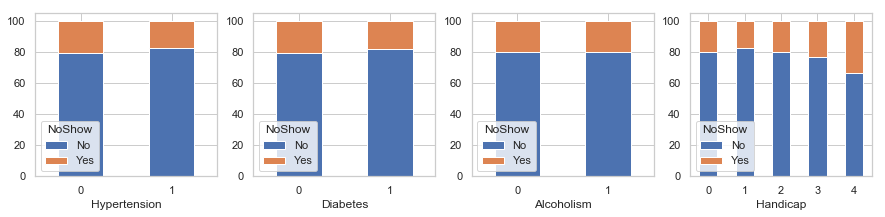

In [504]:
fig, axes = plt.subplots(1,4, figsize=(15,3))
    
plot_rel_noshow(df, 'Hypertension', ax=axes[0])
plot_rel_noshow(df, 'Diabetes', ax=axes[1])
plot_rel_noshow(df, 'Alcoholism', ax=axes[2])
plot_rel_noshow(df, 'Handicap', ax=axes[3])

In [505]:
# Let us check the counts of the different handicap values
df[('Handicap')].value_counts()

0    108279
1      2036
2       183
3        13
4         3
Name: Handicap, dtype: int64

#### Observations
>By plotting the absolute percentage of Shows:NoShows for each medical condition (eg: Diabetes vs No Diabetes), we see that there is no significant difference in the ratios. This allows us to assume that the presence or absence of a medical condition is not a significant predictor of the patient not showing up for an appointment. 
<br><br>
We see that the percentage is higher for handicap=4. However there are only 3 patients with handicap 4 and hence the percentage is skewed, so this cannot be considered as any significant indicator.

### Q2: Is there a relation between demographics and missing the appointment

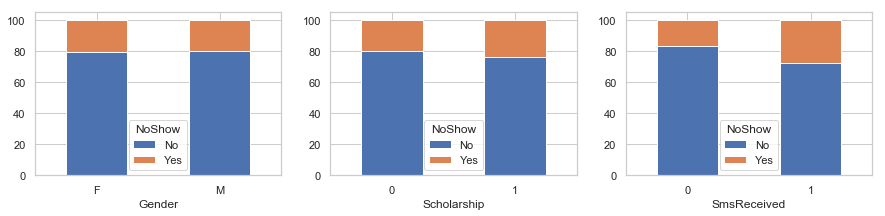

In [506]:
fig, axes = plt.subplots(1,3, figsize=(15,3))

plot_rel_noshow(df, 'Gender', ax=axes[0])
plot_rel_noshow(df, 'Scholarship', ax=axes[1])
plot_rel_noshow(df, 'SmsReceived', ax=axes[2])

In [507]:
df[('SmsReceived')].value_counts()

0    75033
1    35481
Name: SmsReceived, dtype: int64

#### Observations - Gender, Scholarship, SMS Received
> Again there is no significant difference in the relationship between Genders / Scholarships / SmsReceived vs No Shows. In fact the incidence of No-Shows is higher when SMS is received than not. So it doesn't look like a reasonal correlation can be made at this stage based on SMSReceived.

### Understanding the distribution of Age and Neighbourhood

96     17
97     11
98      6
100     4
99      1
Name: Age, dtype: int64

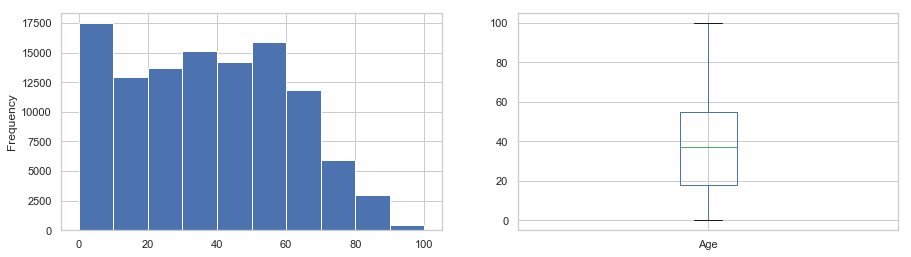

In [508]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
df[('Age')].plot(kind='hist', ax=ax1);
df[('Age')].plot(kind='box', ax=ax2);

df[('Age')].value_counts().tail()

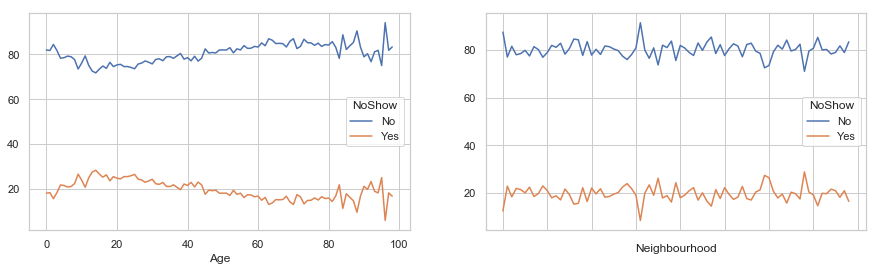

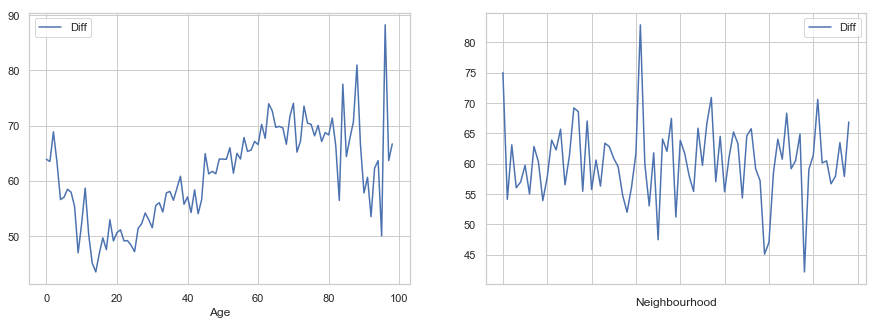

In [509]:
# now checking the relations wrt age and neighbourhood which are not boolean values
fig, axes = plt.subplots(1,2, figsize=(15,4))
plot_rel_noshow(df, 'Age', ax=axes[0], kind='line', percent=True, stacked=False)
plot_rel_noshow(df, 'Neighbourhood', ax=axes[1], kind='line', percent=True, stacked=False)

fig, axes = plt.subplots(1,2, figsize=(15,5))
plot_rel_noshow(df, 'Age', ax=axes[0], kind='line', stacked=False, diff=True)
plot_rel_noshow(df, 'Neighbourhood', ax=axes[1], kind='line', stacked=False, diff=True)


#### Observations - Age / Neighbourhood
> There seems to be some relation between no-shows and the age / neighbourhood. 
While that for age is comparitively smoother, the graph for neighbourhoods has a lot more fluctuation which goes to show that there could be some neighbourhoods where there is a higher probability of a no-show from that particular neighbourhood.
We can explore this further.

In [510]:
# Check the data filtered by a threshold

plot_rel_noshow(df, 'Age', kind='line', stacked=False, diff=True, max_threshold=50, marker='x', debug=True, nograph=True)
print()
plot_rel_noshow(df, 'Neighbourhood', kind='line', stacked=False, diff=True, max_threshold=50, debug=True, nograph=True)

          Diff
Age           
9    46.938776
13   45.058930
14   43.470483
15   46.820809
16   49.643367
17   47.514911
19   49.093264
22   49.090909
23   49.147517
24   48.309179
25   47.147147

                    Diff
Neighbourhood           
ITARARÉ        47.467274
SANTA CECÍLIA  45.089286
SANTA CLARA    47.035573
SANTOS DUMONT  42.163009


#### Observations - Age / Neighbourhood
>We are able to narrow down the data to a smaller range / subset in either of the cases.<br>
**Age:** In the case of age, we see that the highest probablity of noshows come for the appointments booked for patients between the ages of 10 and 25.<br>
**Neighbourhood:** The highest cases of no-shows are from the patients in the neighbourhoods of Itarare, Santa Clara, Santa Cecilia, and Santos Dumont.
<br><br>
Again, these results are not conclusive and doesn't not guarantee predictability, but it is a start to build the prediction models.

### Q3: Is there a relation between dates of scheduling appointments and missing them

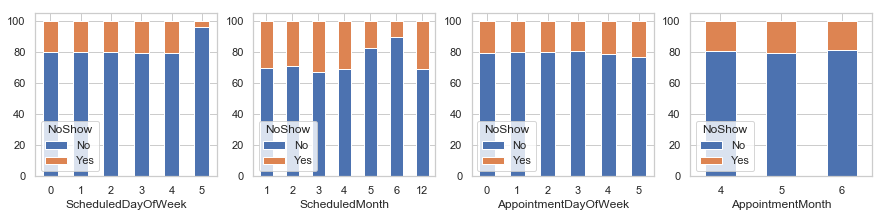

In [511]:
fig, axes = plt.subplots(1,4, figsize=(15,3))

plot_rel_noshow(df, 'ScheduledDayOfWeek', ax=axes[0])
plot_rel_noshow(df, 'ScheduledMonth', ax=axes[1])
plot_rel_noshow(df, 'AppointmentDayOfWeek', ax=axes[2])
plot_rel_noshow(df, 'AppointmentMonth', ax=axes[3])

#### Observations

> Nothing conclusive from the days or months of appointments booked or scheduled, except that appointments which were scheduled on the Friday have least occurances of missing the appointment.

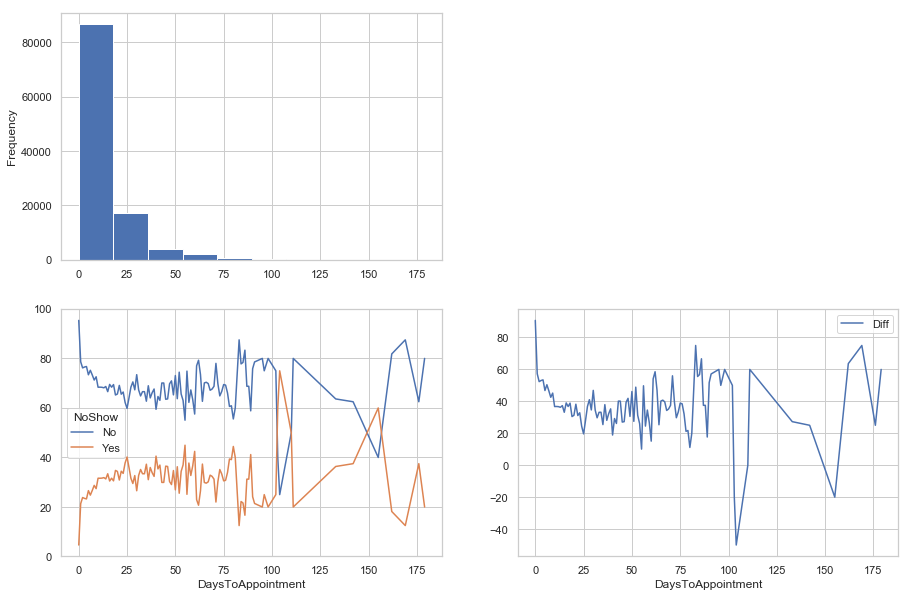

In [512]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
df[('DaysToAppointment')].plot(kind='hist', ax=axes[(0,0)])
axes[(0,1)].remove()
plot_rel_noshow(df, 'DaysToAppointment', kind='line', stacked=False, ax=axes[(1,0)])
plot_rel_noshow(df, 'DaysToAppointment', kind='line', stacked=False, diff=True, ax=axes[(1,1)])

In [513]:
print('appointments > 100 days', df.query('DaysToAppointment > 100').shape)
print('appointments == 0 days', df.query('DaysToAppointment == 0').shape)
df.query('DaysToAppointment < 5').groupby(['DaysToAppointment', 'NoShow']).NoShow.count().unstack().dropna()

appointments > 100 days (138, 19)
appointments == 0 days (38560, 19)


NoShow,No,Yes
DaysToAppointment,,
0,36768,1792
1,4100,1113
2,5122,1602
3,2093,642
4,4059,1231


#### Observations
> The graph significantly jump about when DaysToAppointment is more than 100 days, however the number of records in this segment (~138) is not significant. Whereas 35% of the appointments are booked on the same day as the appointment itself and the incidence of no-shows are relatively less (< 5%). In fact, at between 50 - 100 days the percentage of NoShows seems to be reducing with increase in DayToAppointment. <br>
> We could conclude that booking an appointment much in advance doesn't have a coorelation to incidence of NoShows.

<a id='conclusions'></a>
## Conclusions

Various parameters from the dataset were compared directly to the incidence of NoShow, however nothing was noted that conclusively correlates to a NoShow. 

The best probability was got from the ages and neighbourhood data, where the patients of ages between 10-25 years have the highest probablility of missing their appointment, and the patients from the neighbourhoods of Itarare, Santa Clara, Santa Cecilia, and Santos Dumont similarly have the highest incidence of missing their appointments. 

A model could be built using this Age and Neighbourhood data and can be further refined to consider other attributes as well.

### References
Seaborn Tutorial : https://seaborn.pydata.org/tutorial.html<br>
MatPlotLib Tutorial : https://matplotlib.org/tutorials/index.html<br>
Stackoverflow